# Exercises

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# generation of the stimulus 

duration = 100.
dt = .1
std_dev = 1.
vf_size = (15,15)
n_bins = round(duration / float(dt))

S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

Text(0, 0.5, 'y')

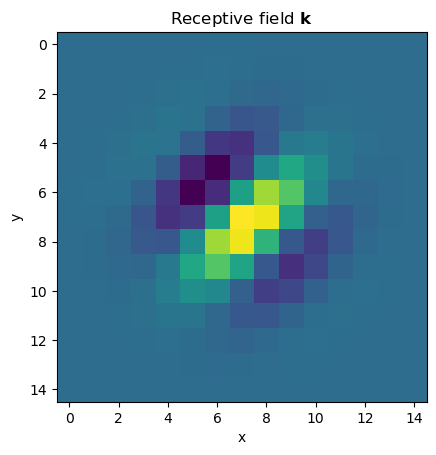

In [2]:
# Defining the gabor patch

size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

plt.imshow(K)
plt.title(r'Receptive field $\bf{k}$')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
def generate_inhomogeneous_poisson_spikes(lamda, dt): # firing rate and time interval

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins) # This is the number of 
                                                                # spikes generated in bin i assuming the maximum rate λ_max.

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max  # acceptance probability vector depending on lamda nature
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])  # random vector of length poisson_numbers[i]
        n_s = int(round(n * dt))

        # This line generates n_s random spike times scaled by dt within the bin starting at bins[i]
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

from scipy.optimize import minimize

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

In [ ]:
spike_rate = 5 # average firing rate 
offset = 2. # offset of the linear stage
durations = [5., 10., 20., 40., 80., 160., 320., 640.]

for d in durations:
    # Also depend on the duration of the stimulus
    n_bins = round(d / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    # --------------------------------------------------
    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]

    # print("average spike rate: %0.2f spikes per second" % (len(spike_times) / duration))

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x
    res = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    print(f"Pearson correlation for duration {d} s: = {res:.3f}")

Pearson correlation for duration 5.0 s: = 0.354
Pearson correlation for duration 10.0 s: = 0.286
Pearson correlation for duration 20.0 s: = 0.466
Pearson correlation for duration 40.0 s: = 0.731
Pearson correlation for duration 80.0 s: = 0.773
Pearson correlation for duration 160.0 s: = 0.845
Pearson correlation for duration 320.0 s: = 0.812
Pearson correlation for duration 640.0 s: = 0.919


It is obvious to see that the Pearson correlation becomes better for a longer stimulus duration. This is because n_bins is equal to duration/dt. With longer recordings we have more data, which leads to a better SNR, a more accurate RF estimation and a higher Pearson correlation.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

In [23]:
# Return to the original stimulus generation
duration = 100.
n_bins = round(d / float(dt))
S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

In [29]:
response_noises = np.sqrt([0, 2, 4, 6, 8, 10])  # different noise levels
N_repeats = 10  # number of repeats for each noise level
mean_corrs = []
std_corrs = []

for noise in response_noises:
    results = np.zeros(N_repeats)

    for i in range(N_repeats):

        # flatten the matrices in to 1d array for convenience
        K_flat = K.ravel()
        K_flat = np.hstack((K.flat, offset))

        S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


        # 1. linear stage
        ks = np.dot(K_flat, S_flat.T)
        # add noise to the linear stage response
        ks_noisy = ks + np.random.normal(0, noise, size=ks.shape)

        # 2. nonlinear stage (for a linear model: f -> identity function)
        lamda = np.exp(ks_noisy)

        # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
        # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
        # across all bins gives the expected number of spikes for the whole draw.
        expected_rate = np.sum(lamda*dt) / duration
        lamda *= (spike_rate / expected_rate)

        # generate spike times using an inhomogeneous Poisson process
        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

        # compute spike counts in the different time bins
        spike_counts = np.histogram(spike_times,
                                    bins=np.arange(n_bins+1)*dt)[0]

        # print("average spike rate: %0.2f spikes per second" % (len(spike_times) / duration))

        k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
        res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'L-BFGS-B', jac = grad) # change method to L-BFGS-B 
                                                                                                                    # for better performance with larger problems

        K_est = res.x
        results[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    # Store the mean and standard deviation for plotting
    mean_corrs.append(np.mean(results))
    std_corrs.append(np.std(results))
    print(f"Pearson correlation for variance {noise**2:.1f}: = {np.mean(results):.3f}")
            

Pearson correlation for variance 0.0: = 0.844
Pearson correlation for variance 2.0: = 0.805
Pearson correlation for variance 4.0: = 0.731
Pearson correlation for variance 6.0: = 0.675
Pearson correlation for variance 8.0: = 0.648
Pearson correlation for variance 10.0: = 0.519


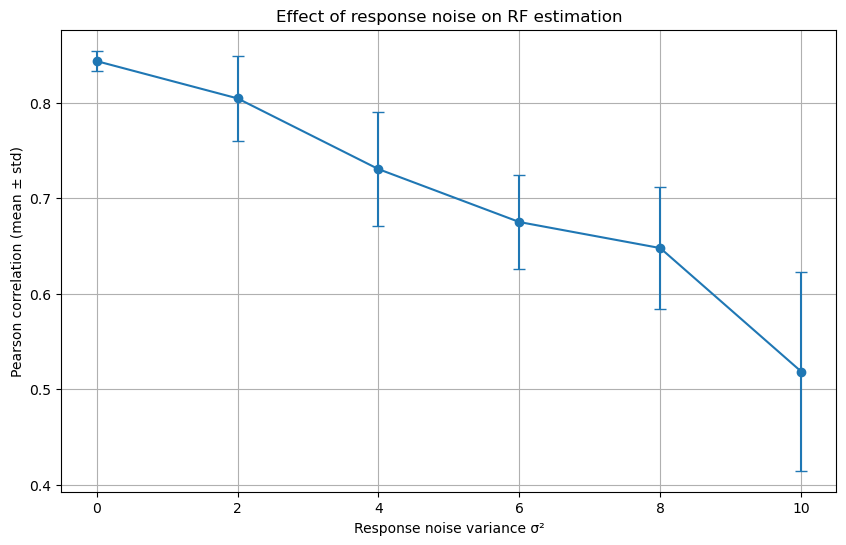

In [36]:
variances = response_noises**2
plt.figure(figsize=(10, 6))
plt.errorbar(variances, mean_corrs, yerr=std_corrs, fmt='-o', capsize=4)
plt.xlabel('Response noise variance σ²')
plt.ylabel('Pearson correlation (mean ± std)')
plt.title('Effect of response noise on RF estimation')
plt.grid(True)
plt.show()

As response noise increases, the Pearson correlation decreases, indicating that higher noise levels make it harder to accurately estimate the receptive field.

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 

### Answer
The terms that are required to maximize the log-likelihood with respect to $\mathbf{k}$ are $ \sum_t r_t \log(\lambda_t )$ and $ - \sum_t \log(\lambda_t \Delta t) $ since $\lambda$ depends on the filter vector $\mathbf{k}$. These become:
$$ \sum_t r_t \, \mathbf{k}^\top \mathbf{s}_t \\
 \sum_t \exp(\mathbf{k}^\top \mathbf{s}_t) \, \Delta t $$
 The other two terms are constant to $\mathbf{k}$ and can be ignored during optimization.
<!-- \mathbf{k}^\top \mathbf{s}_t -->

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 